<a href="https://colab.research.google.com/github/Elieser1945/DeepLearning/blob/main/Deep_Learning_Week_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-on Praktik Deep Learning RNN, LSTM, dan GRU dengan PyTorch

In [1]:
!pip3 install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np

# Arsitektur RNN Sederhana

In [3]:
class SingleRNN(nn.Module):
    def __init__(self, n_inputs, n_neurons):
        super(SingleRNN, self).__init__()

        self.Wx = torch.randn(n_inputs, n_neurons)  # Bobot input
        self.Wy = torch.randn(n_neurons, n_neurons)  # Bobot hidden state
        self.b = torch.zeros(1, n_neurons)  # Bias

    def forward(self, X0, X1):
        self.Y0 = torch.tanh(torch.mm(X0, self.Wx) + self.b)
        self.Y1 = torch.tanh(torch.mm(self.Y0, self.Wy) + torch.mm(X1, self.Wx) + self.b)
        return self.Y0, self.Y1

# LSTM (Long Short Term Memory)

In [4]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])
        return output

# GRU (Gated Recurrent Unit)

In [5]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        output = self.fc(gru_out[:, -1, :])
        return output

# Mengimpor Dataset MNIST

In [10]:
import torchvision
import torchvision.transforms as transforms

BATCH_SIZE = 64
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)


# Membangun Model LSTM untuk Klasifikasi

In [11]:
class ImageLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(ImageLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(-1, 28, 28)  # Mengubah gambar ke format (batch_size, seq_length, input_size)
        lstm_out, _ = self.lstm(x)  # Memasukkan data ke dalam LSTM
        output = self.fc(lstm_out[:, -1, :])  # Mengambil hidden state terakhir dan memprosesnya ke layer output
        return output


# Membangun Model GRU untuk Klasifikasi

In [12]:
class ImageGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(ImageGRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(-1, 28, 28)
        gru_out, _ = self.gru(x)
        output = self.fc(gru_out[:, -1, :])
        return output


# Menyiapkan Fungsi Training dan Evaluasi

In [13]:
import torch.optim as optim

# Fungsi untuk melatih model
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()  # Mengaktifkan mode training
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs = inputs.view(-1, 28, 28)  # Ubah ukuran untuk masuk ke model
            optimizer.zero_grad()  # Reset gradien sebelum forward pass

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Hitung loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update bobot

            running_loss += loss.item()

            # Hitung akurasi training
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")

    print("Training selesai!")

# Fungsi untuk mengevaluasi model
def evaluate_model(model, test_loader):
    model.eval()  # Mengaktifkan mode evaluasi
    correct = 0
    total = 0
    with torch.no_grad():  # Tidak perlu menyimpan gradien saat evaluasi
        for inputs, labels in test_loader:
            inputs = inputs.view(-1, 28, 28)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Akurasi Model di Dataset Test: {accuracy:.2f}%")


# Menjalankan Training dan Evaluasi untuk Model LSTM

In [14]:
# Hyperparameters
input_size = 28
hidden_size = 128
num_layers = 2
output_size = 10
num_epochs = 5
learning_rate = 0.001

# Inisialisasi model, loss function, dan optimizer
lstm_model = ImageLSTM(input_size, hidden_size, num_layers, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)

# Melatih model LSTM
train_model(lstm_model, trainloader, criterion, optimizer, num_epochs)

# Evaluasi model LSTM
evaluate_model(lstm_model, trainloader)


Epoch 1/5, Loss: 0.4151, Accuracy: 86.39%
Epoch 2/5, Loss: 0.1080, Accuracy: 96.78%
Epoch 3/5, Loss: 0.0720, Accuracy: 97.78%
Epoch 4/5, Loss: 0.0542, Accuracy: 98.31%
Epoch 5/5, Loss: 0.0455, Accuracy: 98.64%
Training selesai!
Akurasi Model di Dataset Test: 98.77%


# Menjalankan Training dan Evaluasi untuk Model GRU

In [15]:
# Inisialisasi model, loss function, dan optimizer
gru_model = ImageGRU(input_size, hidden_size, num_layers, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru_model.parameters(), lr=learning_rate)

# Melatih model GRU
train_model(gru_model, trainloader, criterion, optimizer, num_epochs)

# Evaluasi model GRU
evaluate_model(gru_model, trainloader)


Epoch 1/5, Loss: 0.3975, Accuracy: 86.89%
Epoch 2/5, Loss: 0.0954, Accuracy: 97.08%
Epoch 3/5, Loss: 0.0625, Accuracy: 98.06%
Epoch 4/5, Loss: 0.0474, Accuracy: 98.55%
Epoch 5/5, Loss: 0.0372, Accuracy: 98.86%
Training selesai!
Akurasi Model di Dataset Test: 99.08%


# Menampilkan Contoh Prediksi Model

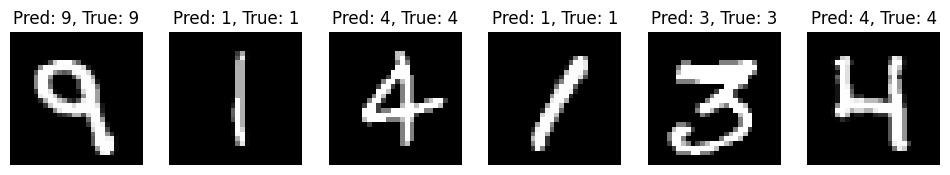

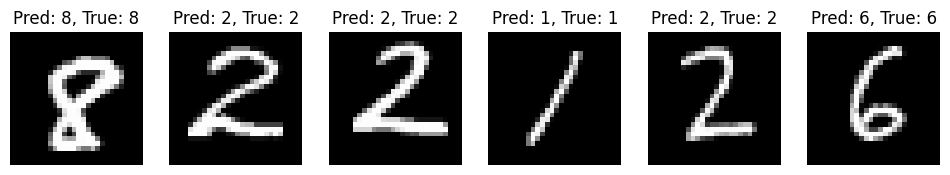

In [16]:
import matplotlib.pyplot as plt

# Fungsi untuk menampilkan gambar dan prediksi
def show_predictions(model, data_loader):
    model.eval()
    images, labels = next(iter(data_loader))
    images = images.view(-1, 28, 28)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, 6, figsize=(12, 4))
    for i in range(6):
        axes[i].imshow(images[i].cpu().numpy().reshape(28, 28), cmap="gray")
        axes[i].set_title(f"Pred: {predicted[i].item()}, True: {labels[i].item()}")
        axes[i].axis("off")

    plt.show()

# Tampilkan prediksi dari model LSTM
show_predictions(lstm_model, trainloader)

# Tampilkan prediksi dari model GRU
show_predictions(gru_model, trainloader)


# Menampilkan Confusion Matrix

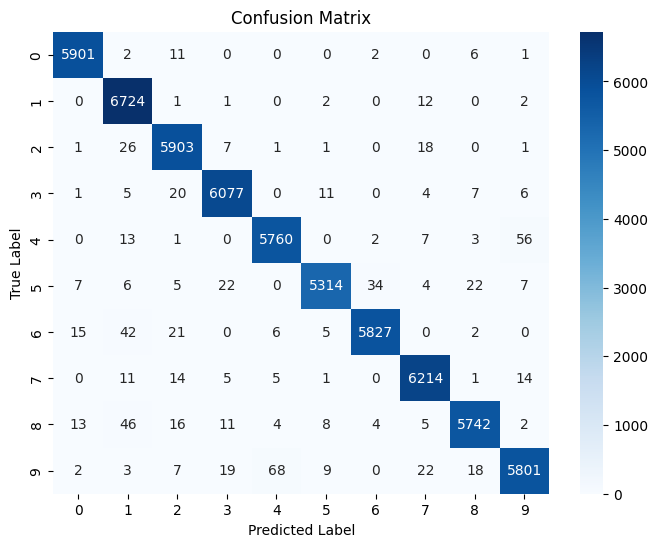

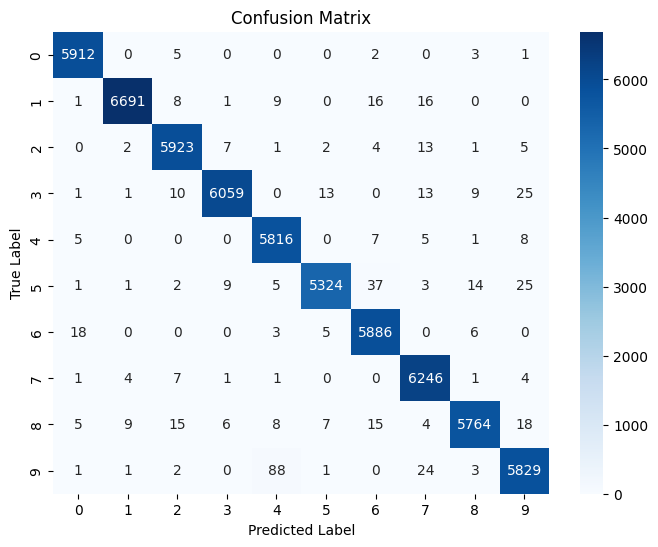

In [17]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Fungsi untuk menghitung dan menampilkan Confusion Matrix
def plot_confusion_matrix(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.view(-1, 28, 28)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Tampilkan Confusion Matrix untuk LSTM
plot_confusion_matrix(lstm_model, trainloader)

# Tampilkan Confusion Matrix untuk GRU
plot_confusion_matrix(gru_model, trainloader)
